# HDA - Final Project
## Project #4, ECG classification


In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import time
import os
import zipfile
from scipy.signal import medfilt
from tqdm import tqdm
from scipy.io import loadmat
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,10)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.fontsize'] = 'large'

# Data processing

## Extract data from the file

In [2]:

# Define the data folder location
data_dir = 'data'

# Extract data from zip file
if not os.path.exists(data_dir):
    with zipfile.ZipFile('data.zip', 'r') as f:
        f.extractall('.')


## Create the datasets and import labels

Our idea is to create a hierarchical model to classify the single lead ECG recordings.  
This is composed by one signle neural network, trained three times with three different datasets.  
With the first NN we find the Atrial Fibrillation (Afib) samples. If the samples are not classified as Afib, then they represent the input samples for the second NN, which aims to find the samples that are labelled as Normal.  
Again, all the samples that are not Afib or Normal are fed to the last NN, that distinguishes between 'Other' and 'Noisy' samples.

In order to do so, we need to create three different datasets:
* 'Afib' class (labelled as 1) against all the others (labelled as 0)
* 'Normal' class (labelled as 1) against 'Other' and 'Noisy' classes (labelled as 0)
* 'Other' class (labelled as 1) against 'Noisy' class (labelled as 0)

We divided the original dataset in 'Train' and 'Test' set, leaving 20% of the samples out for the final testing of the results.  
The training set is used to create the three aforementioned datasets.  

In [3]:

# Create a dataframe containing all the files and the labels from the reference file
reference_df = pd.read_csv('data/REFERENCE-v3.csv', index_col=0, header=None, names=['label'])
train_reference_df, test_reference_df = train_test_split(reference_df, test_size=0.2, stratify=reference_df['label'], random_state=123)

# Replace 'A' with 1 and others with 0
reference_df_Afib = train_reference_df.copy()
reference_df_Afib['label'] = reference_df_Afib['label'].apply(lambda l: 1 if l == 'A' else 0)

# Just consider the 'N' class against 'O' and '~'
mask_Normal = (reference_df['label'] == 'N') | (reference_df['label'] == 'O') | (reference_df['label'] == '~')
reference_df_Normal = train_reference_df.copy()
reference_df_Normal = reference_df_Normal[mask_Normal]
reference_df_Normal['label'] = reference_df_Normal['label'].apply(lambda l: 1 if l == 'N' else 0)

# Just consider the 'O' class against '~'
mask_Other = (reference_df['label'] == 'O') | (reference_df['label'] == '~')
reference_df_Other = train_reference_df.copy()
reference_df_Other = reference_df_Other[mask_Other]
reference_df_Other['label'] = reference_df_Other['label'].apply(lambda l: 1 if l == 'O' else 0)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


 ## Create train and validation sets

Here we further divide the three datasets in 'Train' and 'Validation' set, which will be used to train and evaluate the performances of the three NN.  
We also compute the class weights, that will be used to balance the differences in the number of samples for the two classes of the datasets.

In [4]:
# Keep 20% of the data out for validation
train_reference_df_Afib, val_reference_df_Afib = train_test_split(reference_df_Afib, test_size=0.2, stratify=reference_df_Afib['label'], random_state=123)
# Count the elements in the sets
num_train_data_Afib = sum(train_reference_df_Afib['label'] == 1)
num_train_data_remains_Afib   = sum(train_reference_df_Afib['label'] == 0)
num_val_data_Afib  = sum(val_reference_df_Afib['label'] == 1)
num_val_data_remains_Afib = sum(val_reference_df_Afib['label'] == 0)

weights_Afib = class_weight.compute_class_weight('balanced',
                                            np.unique(train_reference_df_Afib['label']),
                                            train_reference_df_Afib['label'])

print('### Afib DATASET')
print('### TRAIN SET')
print('\tAfib ECG: {} ({:.2f}%)'.format(num_train_data_Afib, 100 * num_train_data_Afib / len(train_reference_df_Afib)))
print('\tRemain ECG: {} ({:.2f}%)'.format(num_train_data_remains_Afib, 100 * num_train_data_remains_Afib / len(train_reference_df_Afib)))
print('### VALIDATION SET')
print('\tAfib ECG: {} ({:.2f}%)'.format(num_val_data_Afib, 100 * num_val_data_Afib / len(val_reference_df_Afib)))
print('\tRemain ECG: {} ({:.2f}%)'.format(num_val_data_remains_Afib, 100 * num_val_data_remains_Afib / len(val_reference_df_Afib)))
print('### CLASS WEIGHTS')
print('\t',weights_Afib)

### Afib DATASET
### TRAIN SET
	Afib ECG: 485 (8.89%)
	Remain ECG: 4972 (91.11%)
### VALIDATION SET
	Afib ECG: 121 (8.86%)
	Remain ECG: 1244 (91.14%)
### CLASS WEIGHTS
	 [0.54877313 5.6257732 ]


In [5]:
# Keep 20% of the data out for validation
train_reference_df_Normal, val_reference_df_Normal = train_test_split(reference_df_Normal, test_size=0.2, stratify=reference_df_Normal['label'], random_state=123)
# Count the elements in the sets
num_train_data_Normal = sum(train_reference_df_Normal['label'] == 1)
num_train_data_remains_Normal   = sum(train_reference_df_Normal['label'] == 0)
num_val_data_Normal  = sum(val_reference_df_Normal['label'] == 1)
num_val_data_remains_Normal = sum(val_reference_df_Normal['label'] == 0)

weights_Normal = class_weight.compute_class_weight('balanced',
                                            np.unique(train_reference_df_Normal['label']),
                                            train_reference_df_Normal['label'])

print('### Normal DATASET')
print('### TRAIN SET')
print('\tNormal ECG: {} ({:.2f}%)'.format(num_train_data_Normal, 100 * num_train_data_Normal / len(train_reference_df_Normal)))
print('\tRemain ECG: {} ({:.2f}%)'.format(num_train_data_remains_Normal, 100 * num_train_data_remains_Normal / len(train_reference_df_Normal)))
print('### VALIDATION SET')
print('\tNormal ECG: {} ({:.2f}%)'.format(num_val_data_Normal, 100 * num_val_data_Normal / len(val_reference_df_Normal)))
print('\tRemain ECG: {} ({:.2f}%)'.format(num_val_data_remains_Normal, 100 * num_val_data_remains_Normal / len(val_reference_df_Normal)))
print('### CLASS WEIGHTS')
print('\t',weights_Normal)

### Normal DATASET
### TRAIN SET
	Normal ECG: 3248 (65.33%)
	Remain ECG: 1724 (34.67%)
### VALIDATION SET
	Normal ECG: 813 (65.35%)
	Remain ECG: 431 (34.65%)
### CLASS WEIGHTS
	 [1.44199536 0.76539409]


In [6]:
# Keep 20% of the data out for validation
train_reference_df_Other, val_reference_df_Other = train_test_split(reference_df_Other, test_size=0.2, stratify=reference_df_Other['label'], random_state=123)
# Count the elements in the sets
num_train_data_Other = sum(train_reference_df_Other['label'] == 1)
num_train_data_remains_Other   = sum(train_reference_df_Other['label'] == 0)
num_val_data_Other  = sum(val_reference_df_Other['label'] == 1)
num_val_data_remains_Other = sum(val_reference_df_Other['label'] == 0)

weights_Other = class_weight.compute_class_weight('balanced',
                                            np.unique(train_reference_df_Other['label']),
                                            train_reference_df_Other['label'])

print('### Other DATASET')
print('### TRAIN SET')
print('\tOther ECG: {} ({:.2f}%)'.format(num_train_data_Other, 100 * num_train_data_Other / len(train_reference_df_Other)))
print('\tRemain ECG: {} ({:.2f}%)'.format(num_train_data_remains_Other, 100 * num_train_data_remains_Other / len(train_reference_df_Other)))
print('### VALIDATION SET')
print('\tOther ECG: {} ({:.2f}%)'.format(num_val_data_Other, 100 * num_val_data_Other / len(val_reference_df_Other)))
print('\tRemain ECG: {} ({:.2f}%)'.format(num_val_data_remains_Other, 100 * num_val_data_remains_Other / len(val_reference_df_Other)))
print('### CLASS WEIGHTS')
print('\t',weights_Other)

### Other DATASET
### TRAIN SET
	Other ECG: 1546 (89.68%)
	Remain ECG: 178 (10.32%)
### VALIDATION SET
	Other ECG: 386 (89.56%)
	Remain ECG: 45 (10.44%)
### CLASS WEIGHTS
	 [4.84269663 0.55756792]


# Processing functions
In this section we define all the utility functions that we will use for the processing of the raw data.
## Load data

In [7]:
def load_data(file_name, data_dir):
    # Load the ECG signal from the .mat file
    data = loadmat((Path(data_dir) / (file_name + '.mat')).as_posix())['val']
    return data.squeeze()


 ## Preprocessing - Baseline wander removal


In [8]:
def baseline_wander_removal(data):
    # Sampling frequency
    fs = 300
    # Baseline estimation
    win_size = int(np.round(0.2 * fs)) + 1
    baseline = medfilt(data, win_size)
    win_size = int(np.round(0.6 * fs)) + 1
    baseline = medfilt(baseline, win_size)
    # Removing baseline
    filt_data = data - baseline
    return filt_data
    

 ## Preprocessing - Normalization


In [9]:

def normalize_data(data):
    # Amplitude estimate
    norm_factor = np.percentile(data, 99) - np.percentile(data, 5)
    return (data / norm_factor)
    

 ## Preprocessing - Random crop
 
 We use the 'Random crop' only for the training datasets.  
 For the validation/test sets the crop is centered in the middle of the signal, in order to perform the validation in the same portion of the signal every time.

In [10]:
def random_crop(data, target_size=9000, center_crop=False):
    N = data.shape[0]
    # Return data if correct size
    if N == target_size:
        return data
    # If data is too small, then pad with zeros
    if N < target_size:
        tot_pads = target_size - N
        left_pads = int(np.ceil(tot_pads / 2))
        right_pads = int(np.floor(tot_pads / 2))
        return np.pad(data, [left_pads, right_pads], mode='constant')
    # Random Crop (always centered if center_crop=True)
    if center_crop:
        from_ = int((N / 2) - (target_size / 2))
    else:
        from_ = np.random.randint(0, np.floor(N - target_size))
    to_ = from_ + target_size
    return data[from_:to_]


## Data loading

In [11]:
def load_and_preprocess_data(file_name, data_dir):
    # Required by tensorflow (strings are passed as bytes)
    if type(file_name) is bytes:
        file_name = file_name.decode()
        data_dir = data_dir.decode()
    # Load data
    data = load_data(file_name, data_dir)
    # Baseline wander removal
    data = baseline_wander_removal(data)
    # Normalize
    data = normalize_data(data)
    return data.astype(np.float32)

 # Dataset
 ## Dataset definition
We now define a function that creates a dataset object and properly maps all the required processing, using the functions defined in the previous section. 

In [12]:
def create_dataset(reference_df, input_size, center_crop, batch_size, shuffle, cache_file=None):
        
    # Convert dataframe to lists
    file_names = list(reference_df.index)
    labels = reference_df['label']
    
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
    
    # Map the load_and_preprocess_data function
    py_func = lambda file_name, label: (tf.py_func(load_and_preprocess_data, [file_name, data_dir], tf.float32), label)
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())
    
    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)
    
    # Shuffle    
    if shuffle:
        dataset = dataset.shuffle(len(file_names))
        
    # Repeat the dataset indefinitely
    dataset = dataset.repeat()
    
    # Map the crop function
    py_func = lambda data, label: (tf.contrib.framework.py_func(random_crop, [data], output_types=tf.float32, output_shapes=input_size), label)
    dataset = dataset.map(py_func)
    
    # Correct input shape for the network
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, 1), label))
    
    # Batch
    dataset = dataset.batch(batch_size=batch_size)
    
    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)
    
    return dataset
    

 ## Dataset initialization
For all the three datasets we create the 'Train' and 'Validation' sets, with the function defined before.  
The 'shuffle' parameter is set to True for the Train set and to False for the Validation; the opposite is done for the 'center_crop' parameter, as explained before. 
We also define the train and validation steps, required during the NN training.

In [13]:
input_size = 9000
batch_size = 20

In [14]:
# Afib
train_dataset_Afib = create_dataset(train_reference_df_Afib, 
                               input_size=input_size, 
                               center_crop=False, 
                               batch_size=batch_size, 
                               shuffle=True,
                               cache_file='train_cache_Afib')

val_dataset_Afib = create_dataset(val_reference_df_Afib, 
                             input_size=input_size, 
                             center_crop=True, 
                             batch_size=batch_size, 
                             shuffle=False,
                             cache_file='val_cache_Afib')

train_steps_Afib = int(np.ceil(len(train_reference_df_Afib)/batch_size))
val_steps_Afib = int(np.ceil(len(val_reference_df_Afib)/batch_size))


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [15]:
# Normal
train_dataset_Normal = create_dataset(train_reference_df_Normal, 
                               input_size=input_size, 
                               center_crop=False, 
                               batch_size=batch_size, 
                               shuffle=True,
                               cache_file='train_cache_Normal')

val_dataset_Normal = create_dataset(val_reference_df_Normal, 
                             input_size=input_size, 
                             center_crop=True, 
                             batch_size=batch_size, 
                             shuffle=False,
                             cache_file='val_cache_Normal')

train_steps_Normal = int(np.ceil(len(train_reference_df_Normal)/batch_size))
val_steps_Normal = int(np.ceil(len(val_reference_df_Normal)/batch_size))


In [16]:
# Other
train_dataset_Other = create_dataset(train_reference_df_Other, 
                               input_size=input_size, 
                               center_crop=False, 
                               batch_size=batch_size, 
                               shuffle=True,
                               cache_file='train_cache_Other')

val_dataset_Other = create_dataset(val_reference_df_Other, 
                             input_size=input_size, 
                             center_crop=True, 
                             batch_size=batch_size, 
                             shuffle=False,
                             cache_file='val_cache_Other')

train_steps_Other = int(np.ceil(len(train_reference_df_Other)/batch_size))
val_steps_Other = int(np.ceil(len(val_reference_df_Other)/batch_size))


## Cache
For all the three datasets we prepare the cache to speed up the next steps of the algorithm.  
We can see that the first epoch takes longer to load, but the following ones are considerably faster.

In [17]:
# Define an iterator to get data
iterator = train_dataset_Afib.make_one_shot_iterator()
next_element = iterator.get_next()
# Start a new session
with tf.Session() as sess:
    # Iterate for 3 epochs
    for num_epoch in range(3):
        # Time the loading time
        it = time.time()
        for step in tqdm(range(3)):
                # Get the next batch of data
                data, label = sess.run(next_element)
        # Print loading time
        print('EPOCH {} - Time to load the entire dataset [seconds]: {}'.format(num_epoch+1, time.time() - it))

100%|██████████| 3/3 [00:00<00:00, 245.94it/s]

EPOCH 1 - Time to load the entire dataset [seconds]: 2.7339024543762207
EPOCH 2 - Time to load the entire dataset [seconds]: 0.019646883010864258
EPOCH 3 - Time to load the entire dataset [seconds]: 0.017835378646850586


In [18]:
# Define an iterator to get data
iterator = train_dataset_Normal.make_one_shot_iterator()
next_element = iterator.get_next()
# Start a new session
with tf.Session() as sess:
    # Iterate for 3 epochs
    for num_epoch in range(3):
        # Time the loading time
        it = time.time()
        for step in tqdm(range(3)):
                # Get the next batch of data
                data, label = sess.run(next_element)
        # Print loading time
        print('EPOCH {} - Time to load the entire dataset [seconds]: {}'.format(num_epoch+1, time.time() - it))

100%|██████████| 3/3 [00:00<00:00, 260.28it/s]

EPOCH 1 - Time to load the entire dataset [seconds]: 1.528472900390625
EPOCH 2 - Time to load the entire dataset [seconds]: 0.018021106719970703
EPOCH 3 - Time to load the entire dataset [seconds]: 0.01629042625427246


In [19]:
# Define an iterator to get data
iterator = train_dataset_Other.make_one_shot_iterator()
next_element = iterator.get_next()
# Start a new session
with tf.Session() as sess:
    # Iterate for 3 epochs
    for num_epoch in range(3):
        # Time the loading time
        it = time.time()
        for step in tqdm(range(3)):
                # Get the next batch of data
                data, label = sess.run(next_element)
        # Print loading time
        print('EPOCH {} - Time to load the entire dataset [seconds]: {}'.format(num_epoch+1, time.time() - it))

100%|██████████| 3/3 [00:00<00:00, 157.20it/s]

EPOCH 1 - Time to load the entire dataset [seconds]: 0.5045361518859863
EPOCH 2 - Time to load the entire dataset [seconds]: 0.020093441009521484
EPOCH 3 - Time to load the entire dataset [seconds]: 0.022237300872802734


 # RNN Model

 - Input of shape (None, 9000, 1)
 - Layer 1
   - Conv1D with 32 channels, kernel size 9, and stride 4
   - Batchnorm
   - ReLu
 - Layer 2
   - Conv1D with 64 channels, kernel size 9, and stride 4
   - Batchnorm
   - ReLu
 - Layer 3
   - Conv1D with 128 channels, kernel size 9, and stride 4
   - Batchnorm
   - ReLu
 - Layer 4
   - GRU with 128 units
 - Layer 5
   - Dense with 1 output (probability of the input sample to be an Afib)


In [20]:
def MyModel(input_shape):
    """
    Arguments:
    input_shape -- shape of the data of the dataset

    Returns:
    model -- a tf.keras.Model() instance
    """
    
    X_input = tf.keras.Input(input_shape)

    # CONV -> Batch Normalization -> ReLU Block applied to X
    X = tf.keras.layers.Conv1D(32, 9, strides=4, name='conv0')(X_input)
    X = tf.keras.layers.BatchNormalization(axis=2, name='bn0')(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv1D(64, 9, strides=4, name='conv1')(X)
    X = tf.keras.layers.BatchNormalization(axis=2, name='bn1')(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv1D(128, 9, strides=4, name='conv2')(X)
    X = tf.keras.layers.BatchNormalization(axis=2, name='bn2')(X)
    X = tf.keras.layers.Activation('relu')(X)

    # GRU 
    X = tf.keras.layers.GRU(128, name='gru0')(X)

    # FLATTEN X + FULLYCONNECTED
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = tf.keras.Model(inputs = X_input, outputs = X, name='MyModel')
        
    return model

## Weighted loss
We now define a custom weighted binary crossentropy loss, using the weights computed before for each class.

In [21]:
def weighted_binary_crossentropy_Afib(y_true, y_pred):
    # Calculate the binary crossentropy
    b_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * weights_Afib[0] + (1. - y_true) * weights_Afib[1]
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return tf.keras.backend.mean(weighted_b_ce)


In [22]:
def weighted_binary_crossentropy_Normal(y_true, y_pred):
    # Calculate the binary crossentropy
    b_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * weights_Normal[0] + (1. - y_true) * weights_Normal[1]
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return tf.keras.backend.mean(weighted_b_ce)


In [23]:
def weighted_binary_crossentropy_Other(y_true, y_pred):
    # Calculate the binary crossentropy
    b_ce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * weights_Other[0] + (1. - y_true) * weights_Other[1]
    weighted_b_ce = weight_vector * b_ce

    # Return the mean error
    return tf.keras.backend.mean(weighted_b_ce)


## RNN
For each dataset we compile the defined model with our custom loss function.

In [24]:
# Afib model
input_shape = (input_size, 1)
model_Afib = MyModel(input_shape)

model_Afib.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])


Instructions for updating:
Colocations handled automatically by placer.


In [25]:
# Normal model
input_shape = (input_size, 1)
model_Normal = MyModel(input_shape)

model_Normal.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

In [26]:
# Other model
input_shape = (input_size, 1)
model_Other = MyModel(input_shape)

model_Other.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

## Training

We train the models for 30 epochs: we are limited in the computational power and time, but it appeared to us a good compromise to understand the capabilities of our models.  
We then save the models to load them in the future, without trainig them every time.

In [27]:
# Set the number of epochs
num_epochs = 30

In [29]:
history = model_Afib.fit(train_dataset_Afib, epochs=num_epochs, steps_per_epoch=train_steps_Afib, validation_data=val_dataset_Afib, 
                    validation_steps=val_steps_Afib)
# Save the model
model_Afib.save('model_Afib_uni_noW.h5')


Instructions for updating:
Use tf.cast instead.
Epoch 1/30
273/273 [==============================] - 102s 373ms/step - loss: 0.3071 - acc: 0.9084 - val_loss: 0.3031 - val_acc: 0.9116
Epoch 2/30
273/273 [==============================] - 99s 364ms/step - loss: 0.2572 - acc: 0.9132 - val_loss: 0.3137 - val_acc: 0.9094
Epoch 3/30
273/273 [==============================] - 100s 366ms/step - loss: 0.1909 - acc: 0.9253 - val_loss: 0.1956 - val_acc: 0.9203
Epoch 4/30
273/273 [==============================] - 101s 370ms/step - loss: 0.1599 - acc: 0.9368 - val_loss: 0.1742 - val_acc: 0.9275
Epoch 5/30
273/273 [==============================] - 100s 365ms/step - loss: 0.1252 - acc: 0.9516 - val_loss: 0.1633 - val_acc: 0.9355
Epoch 6/30
273/273 [==============================] - 99s 363ms/step - loss: 0.1118 - acc: 0.9562 - val_loss: 0.1467 - val_acc: 0.9428
Epoch 7/30
273/273 [==============================] - 99s 364ms/step - loss: 0.0897 - acc: 0.9674 - val_loss: 0.1534 - val_acc: 0.9442
Epo

In [ ]:
history = model_Normal.fit(train_dataset_Normal, epochs=num_epochs, steps_per_epoch=train_steps_Normal, validation_data=val_dataset_Normal, 
                    validation_steps=val_steps_Normal)
# Save the model
model_Normal.save('model_Normal_uni_noW.h5')

Epoch 1/30
249/249 [==============================] - 95s 383ms/step - loss: 0.6553 - acc: 0.6450 - val_loss: 0.6760 - val_acc: 0.6500
Epoch 2/30
249/249 [==============================] - 89s 359ms/step - loss: 0.6111 - acc: 0.6751 - val_loss: 0.6324 - val_acc: 0.6468
Epoch 3/30
249/249 [==============================] - 90s 361ms/step - loss: 0.5384 - acc: 0.7313 - val_loss: 0.5221 - val_acc: 0.7468
Epoch 4/30
249/249 [==============================] - 90s 361ms/step - loss: 0.4243 - acc: 0.8108 - val_loss: 0.4543 - val_acc: 0.8000
Epoch 5/30
249/249 [==============================] - 90s 361ms/step - loss: 0.3552 - acc: 0.8498 - val_loss: 0.4500 - val_acc: 0.8151
Epoch 6/30
249/249 [==============================] - 90s 361ms/step - loss: 0.3200 - acc: 0.8679 - val_loss: 0.4007 - val_acc: 0.8579
Epoch 7/30
249/249 [==============================] - 90s 360ms/step - loss: 0.2847 - acc: 0.8896 - val_loss: 0.3967 - val_acc: 0.8571
Epoch 8/30
249/249 [==============================] - 9

In [28]:
history = model_Other.fit(train_dataset_Other, epochs=num_epochs, steps_per_epoch=train_steps_Other, validation_data=val_dataset_Other, 
                    validation_steps=val_steps_Other)
# Save the model
model_Other.save('model_Other_uni_noW.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
87/87 [==============================] - 34s 387ms/step - loss: 0.2734 - acc: 0.8931 - val_loss: 0.6259 - val_acc: 0.8977
Epoch 2/30
87/87 [==============================] - 29s 331ms/step - loss: 0.1993 - acc: 0.9011 - val_loss: 0.5804 - val_acc: 0.9068
Epoch 3/30
87/87 [==============================] - 29s 331ms/step - loss: 0.1662 - acc: 0.9293 - val_loss: 1.0576 - val_acc: 0.1318
Epoch 4/30
87/87 [==============================] - 29s 329ms/step - loss: 0.1220 - acc: 0.9425 - val_loss: 0.9850 - val_acc: 0.3500
Epoch 5/30
87/87 [==============================] - 29s 329ms/step - loss: 0.1193 - acc: 0.9506 - val_loss: 0.2378 - val_acc: 0.9227
Epoch 6/30
87/87 [==============================] - 29s 329ms/step - loss: 0.0867 - acc: 0.9667 - val_loss: 0.2612 - val_acc: 0.8682
Epoch 7/30
87/87 [==============================] - 29s 330ms/step - loss: 0.0847 - acc: 0.9678 - val_loss: 0.2143 - val_acc: 0.9114
Epoch 8/30
87/87 [===

## Model loading
Here we load the saved trained models.

In [28]:
# Load the models
model_Afib = tf.keras.models.load_model('model_Afib_uni_noW.h5')

model_Normal = tf.keras.models.load_model('model_Normal_uni_noW.h5')

model_Other = tf.keras.models.load_model('model_Other_uni_noW.h5')

Instructions for updating:
Use tf.cast instead.


## Validation results

We now compute some metrics to check the quality for every single model, before using them for the final cascade classification.

#### VALIDATION PERFORMANCE Afib
Accuracy: 95.16%
Precision (fraction of ECG classified as Afib that are actually Afib): 72.00%
Recall (fraction of Afib correctly classified as Afib): 74.38%
Fscore (harmonic mean of precision and recall): 73.17%


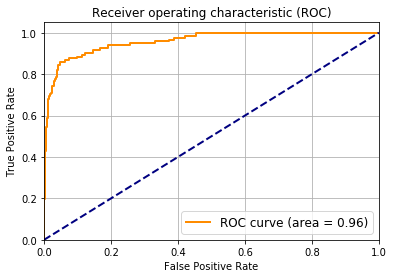

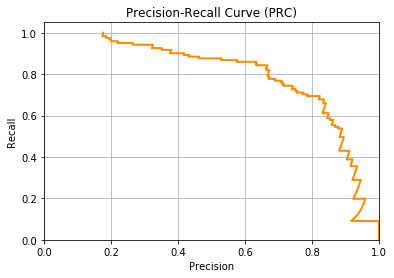

In [40]:
# Get the validation labels
val_labels = val_reference_df_Afib['label'].values
# Get the network output for the validation set
val_preds = model_Afib.predict(val_dataset_Afib, steps=val_steps_Afib)[:len(val_labels)].squeeze()
# Get the estimated classes
val_est_classes = (val_preds > 0.5).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(val_labels, val_est_classes)

# Evaluate precision, recall and fscore
precision, recall, fscore, _ = precision_recall_fscore_support(val_labels, val_est_classes, average='binary')

print('#### VALIDATION PERFORMANCE Afib')
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision (fraction of ECG classified as Afib that are actually Afib): {:.2f}%'.format(precision*100))
print('Recall (fraction of Afib correctly classified as Afib): {:.2f}%'.format(recall*100))
print('Fscore (harmonic mean of precision and recall): {:.2f}%'.format(fscore*100))

# ROC curve
fpr, tpr, _ = roc_curve(val_labels, val_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('ROC_Afib_FinalProjBrex_noWeight.eps', format='eps')

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(val_labels, val_preds)

plt.figure()
plt.plot(prec, rec, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve (PRC)')
plt.savefig('PRC_Afib_FinalProjBrex_noWeight.eps', format='eps')

#### VALIDATION PERFORMANCE Normal
Accuracy: 84.24%
Precision (fraction of ECG classified as Normal that are actually Normal): 85.58%
Recall (fraction of Normal correctly classified as Normal): 91.27%
Fscore (harmonic mean of precision and recall): 88.33%


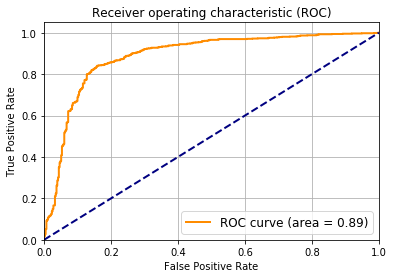

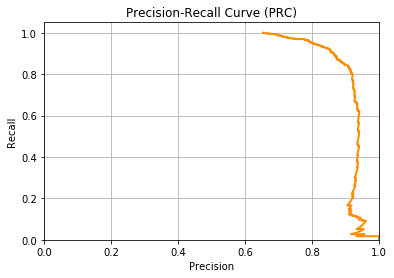

In [41]:
# Get the validation labels
val_labels = val_reference_df_Normal['label'].values
# Get the network output for the validation set
val_preds = model_Normal.predict(val_dataset_Normal, steps=val_steps_Normal)[:len(val_labels)].squeeze()
# Get the estimated classes
val_est_classes = (val_preds > 0.5).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(val_labels, val_est_classes)

# Evaluate precision, recall and fscore
precision, recall, fscore, _ = precision_recall_fscore_support(val_labels, val_est_classes, average='binary')

print('#### VALIDATION PERFORMANCE Normal')
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision (fraction of ECG classified as Normal that are actually Normal): {:.2f}%'.format(precision*100))
print('Recall (fraction of Normal correctly classified as Normal): {:.2f}%'.format(recall*100))
print('Fscore (harmonic mean of precision and recall): {:.2f}%'.format(fscore*100))

# ROC curve
fpr, tpr, _ = roc_curve(val_labels, val_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('ROC_Normal_FinalProjBrex_noWeight.eps', format='eps')
# Precision-Recall curve
prec, rec, _ = precision_recall_curve(val_labels, val_preds)

plt.figure()
plt.plot(prec, rec, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve (PRC)')
plt.savefig('PRC_Normal_FinalProjBrex_noWeight.eps', format='eps')

#### VALIDATION PERFORMANCE Other
Accuracy: 92.34%
Precision (fraction of ECG classified as Other that are actually Other): 94.91%
Recall (fraction of Other correctly classified as Other): 96.63%
Fscore (harmonic mean of precision and recall): 95.76%


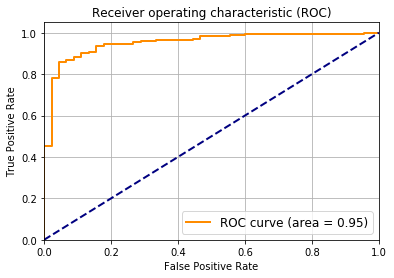

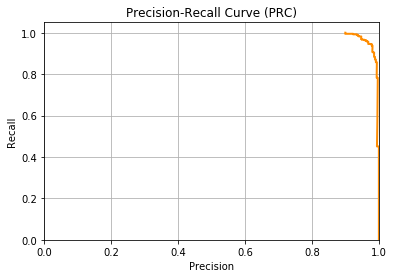

In [42]:
# Get the validation labels
val_labels = val_reference_df_Other['label'].values
# Get the network output for the validation set
val_preds = model_Other.predict(val_dataset_Other, steps=val_steps_Other)[:len(val_labels)].squeeze()
# Get the estimated classes
val_est_classes = (val_preds > 0.5).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(val_labels, val_est_classes)

# Evaluate precision, recall and fscore
precision, recall, fscore, _ = precision_recall_fscore_support(val_labels, val_est_classes, average='binary')

print('#### VALIDATION PERFORMANCE Other')
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision (fraction of ECG classified as Other that are actually Other): {:.2f}%'.format(precision*100))
print('Recall (fraction of Other correctly classified as Other): {:.2f}%'.format(recall*100))
print('Fscore (harmonic mean of precision and recall): {:.2f}%'.format(fscore*100))

# ROC curve
fpr, tpr, _ = roc_curve(val_labels, val_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('ROC_Other_FinalProjBrex_noWeight.eps', format='eps')

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(val_labels, val_preds)

plt.figure()
plt.plot(prec, rec, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve (PRC)')
plt.savefig('PRC_Other_FinalProjBrex_noWeight.eps', format='eps')


# Final classification
We now create our testing dataset and we then proceed to define the cascade classifier for the final and complete classification.

## Testing dataset creation
Here we create our testing dataset as we have done before.  
We assign to each label a number from zero to three, just in order to facilitate the process and the calculation of the performances:
* N = 0
* A = 1
* O = 2
* ~ = 3

In [43]:
# Encoding
test_reference_df['label'] = test_reference_df['label'].apply(lambda l: 0 if l == 'N' else l)
test_reference_df['label'] = test_reference_df['label'].apply(lambda l: 1 if l == 'A' else l)
test_reference_df['label'] = test_reference_df['label'].apply(lambda l: 2 if l == 'O' else l)
test_reference_df['label'] = test_reference_df['label'].apply(lambda l: 3 if l == '~' else l)

# Dataset creation
testing_dataset = create_dataset(test_reference_df, 
                               input_size=input_size, 
                               center_crop=True, 
                               batch_size=batch_size, 
                               shuffle=False,
                               cache_file='testing_cache')

testing_steps = int(np.ceil(len(test_reference_df)/batch_size))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



## Classificator
Here we define the function that, given the three trained models, returns the final predicted labels.  
This is done with the cascade classifier described at the beginning. 

In [44]:
def classificator (model_Afib, model_Normal, model_Other, labels, dataset, data_steps):
    
    preds_1 = model_Afib.predict(dataset, steps=data_steps)[:len(labels)].squeeze()
    class_1 = (preds_1 > 0.5).astype(int)
    
    preds_2 = model_Normal.predict(dataset, steps=data_steps)[:len(labels)].squeeze()
    class_2 = (preds_2 > 0.5).astype(int)
    
    preds_3 = model_Other.predict(dataset, steps=data_steps)[:len(labels)].squeeze()
    class_3 = (preds_3 > 0.5).astype(int)
    
    est_labels = np.zeros(len(labels))
    
    for k in range(len(labels)):
        if (class_1[k]==1):
            est_labels[k] = 1
        elif(class_2[k]==1):
            est_labels[k] = 0
        elif(class_3[k]==1):
            est_labels[k] = 2
        else:
            est_labels[k] = 3
        
    return est_labels.astype(int)


In [45]:
true_labels = test_reference_df['label'].values
estimated_labels = classificator(model_Afib, model_Normal, model_Other, true_labels, testing_dataset, testing_steps)

## Overall performances

Here we compute the final performances of our model.  
We decided to look at the usual performance metrics: precision, recall, fscore and accuracy.

In [46]:
# Evaluate accuracy
accuracy = accuracy_score(true_labels, estimated_labels)

# Evaluate precision, recall and fscore
precision, recall, fscore, _ = precision_recall_fscore_support(true_labels, estimated_labels, average=None)

print('#### TESTING PERFORMANCE')
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: ', format(precision*100))
print('Recall:    ', format(recall*100))
print('Fscore:    ', format(fscore*100))

#### TESTING PERFORMANCE
Accuracy: 81.18%
Precision:  [85.27272727 70.70063694 76.73267327 57.77777778]
Recall:     [92.4137931  73.02631579 64.18219462 46.42857143]
Fscore:     [88.69976359 71.84466019 69.89853439 51.48514851]


## F1 score

As the last overall performance metric we computed the total F1 score.  
We used it to compare our work with the others from the 2017 PhysioNet challenge.
As there were two different definitions of the value, we computed both of them.  

The first one considers the scores of all the four classes:  
![equation](photo_2019-09-05_11-34-32.jpg)  
The second leaves out the noisy class:  
![equation](photo_2019-09-05_11-34-39.jpg)

In [47]:
F1_4 = (fscore[0] + fscore[1] + fscore[2] + fscore[3]) / 4
F1_3 = (fscore[0] + fscore[1] + fscore[2]) / 3

print('F1 score with 4 classes: ', F1_4)
print('F1 score with 3 classes: ', F1_3)

F1 score with 4 classes:  0.7048202667199405
F1 score with 3 classes:  0.7681431939104156


## Performances of the single classificators

Here we present the performances of the three classificators with the testing dataset.  
We see that for the first model the results are similar to the ones obtained for the validation set previously analyzed: this is due to the fact that the dataset in which the testing is performed has the same distribution of samples as the one used for the training.  
This is not the case for the other two models: in the testing dataset we have not discarded 'Afib' samples and 'Afib and Normal' samples for the second and third model respectively.  
But this does not interfere with the overall results of the classification, as what we are interested in is a good value of the 'recall' metric: this tells us the number of samples of a given label correctly classified as that label, which is the objective of the single models.

In [48]:
# Afib results
preds_1 = model_Afib.predict(testing_dataset, steps=testing_steps)[:len(true_labels)].squeeze()
class_1 = (preds_1 > 0.5).astype(int)
    
true_labels1 = (true_labels == 1).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(true_labels1, class_1)

# Evaluate precision, recall and fscore
precision, recall, fscore, _ = precision_recall_fscore_support(true_labels1, class_1, average='binary')

print('#### VALIDATION PERFORMANCE Afib')
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision (fraction of ECG classified as Afib that are actually Afib): {:.2f}%'.format(precision*100))
print('Recall (fraction of Afib correctly classified as Afib): {:.2f}%'.format(recall*100))
print('Fscore (harmonic mean of precision and recall): {:.2f}%'.format(fscore*100))

#### VALIDATION PERFORMANCE Afib
Accuracy: 95.02%
Precision (fraction of ECG classified as Afib that are actually Afib): 71.90%
Recall (fraction of Afib correctly classified as Afib): 72.37%
Fscore (harmonic mean of precision and recall): 72.13%


In [49]:
# Normal results
preds_2 = model_Normal.predict(testing_dataset, steps=testing_steps)[:len(true_labels)].squeeze()
class_2 = (preds_2 > 0.5).astype(int)

true_labels2 = (true_labels == 0).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(true_labels2, class_2)

# Evaluate precision, recall and fscore
precision, recall, fscore, _ = precision_recall_fscore_support(true_labels2, class_2, average='binary')

print('#### VALIDATION PERFORMANCE Normal')
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision (fraction of ECG classified as Normal that are actually Normal): {:.2f}%'.format(precision*100))
print('Recall (fraction of Normal correctly classified as Normal): {:.2f}%'.format(recall*100))
print('Fscore (harmonic mean of precision and recall): {:.2f}%'.format(fscore*100))

#### VALIDATION PERFORMANCE Normal
Accuracy: 85.40%
Precision (fraction of ECG classified as Normal that are actually Normal): 84.44%
Recall (fraction of Normal correctly classified as Normal): 92.51%
Fscore (harmonic mean of precision and recall): 88.29%


In [50]:
# Other results
preds_3 = model_Other.predict(testing_dataset, steps=testing_steps)[:len(true_labels)].squeeze()
class_3 = (preds_3 > 0.5).astype(int)

true_labels3 = (true_labels == 2).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(true_labels3, class_3)

# Evaluate precision, recall and fscore
precision, recall, fscore, _ = precision_recall_fscore_support(true_labels3, class_3, average='binary')

print('#### VALIDATION PERFORMANCE Other')
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision (fraction of ECG classified as Other that are actually Other): {:.2f}%'.format(precision*100))
print('Recall (fraction of Other correctly classified as Other): {:.2f}%'.format(recall*100))
print('Fscore (harmonic mean of precision and recall): {:.2f}%'.format(fscore*100))

#### VALIDATION PERFORMANCE Other
Accuracy: 32.42%
Precision (fraction of ECG classified as Other that are actually Other): 29.17%
Recall (fraction of Other correctly classified as Other): 97.10%
Fscore (harmonic mean of precision and recall): 44.86%


## RANK

Based on the results of the 2017 PhysioNet Challenge, we would have arrived 34th, with the 7th best result :)  